# TP2 : MCMC (Partie 1)

## G3 SDI - Estimation Avancée

Dans ce TP, on s'intéresse aux méthodes d'échantillonnage dites "MCMC" (Monte Carlo par Chaînes de Markov). Le premier exercice consiste à implémenter un Metropolis-Hastings et de regarder l'influence de quelques paramètres. Dans un deuxième exercice, on cherchera à implémenter un échantillonneur de Gibbs dans un modèle de régression linéaire bayésienne (disponible dans un deuxième notebook).

### Instructions

1. Renommez votre notebook sous la forme `tp2a_Nom1_Nom2.ipynb`. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposez votre notebook sur Moodle dans la section prévue à cet effet avant la date limite.

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Compte-rendu écrit par AMORRI Farah, MILANO Olivia, 03/12/2025.
</div>

In [19]:
# Usual libraries
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss

### Exercice - Régression logistique bayésienne

Soit le modèle de régression logistique 1D suivant :
\begin{align}
\beta & \sim \mathcal{N}(0,4) \\
y | x_i, \beta & \sim \text{Bernoulli} \left( \frac{1}{1+\exp(-\beta x)} \right)
\end{align}

(I.e., on suppose que l'intercept vaut 0 pour simplifier).

Le posterior $p(\beta|\mathcal{D})$ est intractable, on va donc chercher à en tirer des échantillons par un algorithme Metropolis-Hastings (MH). On prendra comme loi instrumentale une loi normale centrée en l'état courant et de variance $\sigma^2$.


In [20]:
# Generate fake data from the model

np.random.seed(2024)

b = -2.5
N = 50
x = np.random.randn(N)
p = 1/(1+np.exp(-b*x))
y = np.random.rand(N) < p

**Q1.** Écrire une fonction implémentant l'algorithme MH proposé pour tirer des échantillons de $p(\beta|\mathcal{D})$, qui prend comme arguments :
* La taille de la chaine N ;
* L'état initial de la chaîne $\beta^{(0)}$ ;
* L'écart-type $\sigma$ de la *proposal* gaussienne ;
* Une graine aléatoire.

On utilisera les fonctions implémentées dans `scipy.stats` pour les pdfs !

In [21]:


def likelihood(x,y,beta):
    p_conjointe_xybeta = 1
    for xi, yi in zip(x, y):
        p = 1/(1+np.exp(-beta*xi))
        p_conjointe_xiybeta = ss.bernoulli.pmf(k=yi, p=p)
        p_conjointe_xybeta *= p_conjointe_xiybeta

    # p_beta = ss.norm.pdf(loc=0, scale=4)

    # ll = p_conjointe_xybeta / p_beta
    ll = p_conjointe_xybeta 

    return ll 



def mh(N, beta0, sigma, seed):
    np.random.seed(seed)
    beta = beta0
    stockage = [beta]
    for i in range(N):
        beta_old = beta
        #on utilise rvs car on VEUT bouger aléatoirement
        beta_new = ss.norm.rvs(loc=beta_old, scale=sigma)

        ll_new =  likelihood(x,y,beta_new)
        prior_new = ss.norm.pdf(beta_new, loc=0, scale=2)
        ll_old = likelihood(x,y,beta_old)
        prior_old = ss.norm.pdf(beta_old, loc=0, scale=2)

        pi_ratio = (ll_new*prior_new) / (ll_old*prior_old)

        q_new_old = ss.norm.pdf(beta_new, loc=beta_old, scale=sigma)
        q_old_new = ss.norm.pdf(beta_old, loc=beta_new, scale=sigma)

        q_ratio = q_old_new / q_new_old

        ratio = pi_ratio * q_ratio

        alpha = min(1, ratio)

        if alpha > 1-alpha:
            beta = beta_new
            
        else :
            beta = beta_old

        stockage.append(beta)

    return stockage

**Q2**. Prendre $N = 2000$ et $\beta^{(0)} = -1.5$. Afficher les *traceplots* (i.e. les échantillons en fonction de $n$) de la chaîne pour des valeurs différentes de $\sigma$ : $0.01, 0.5, 20$. Dans chaque cas, tracer un histogramme des échantillons obtenus. Commenter.

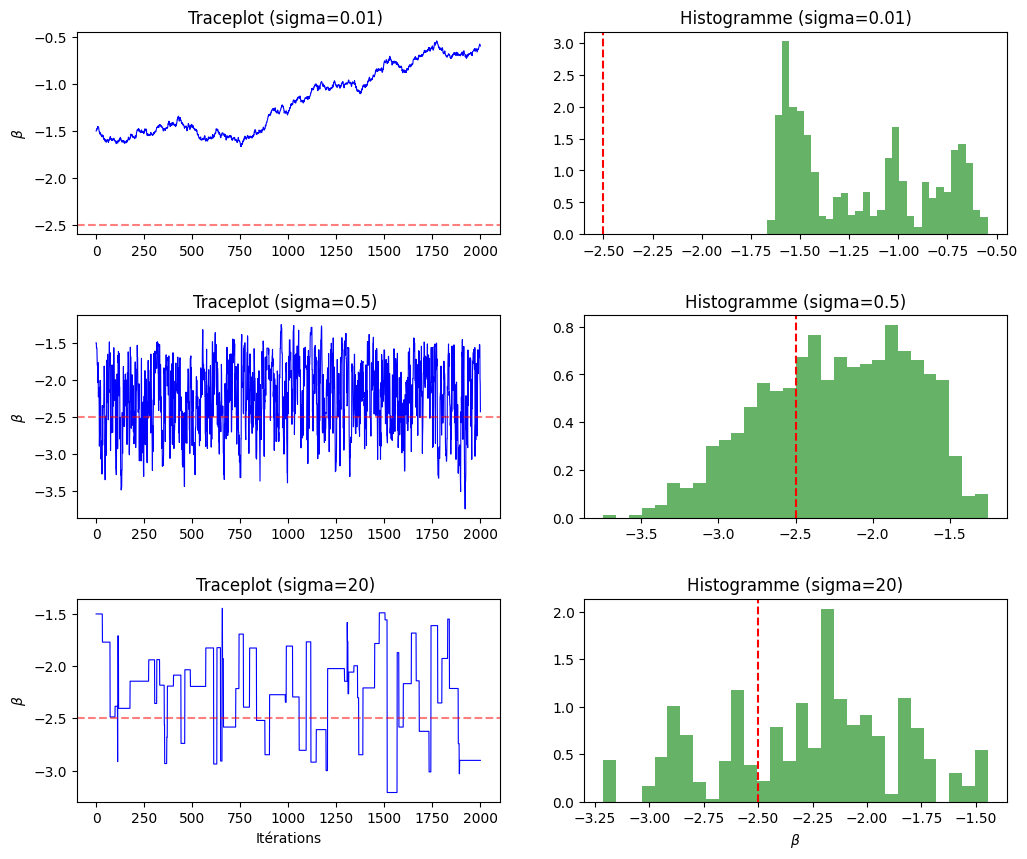

In [22]:


sigmas = [0.01, 0.5, 20]
Ns = 2000
beta0 = -1.5
seed = 42
b_true = -2.5

# Préparation de la figure
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.4)

for i, sigma in enumerate(sigmas):
    # Lancement de l'algo
    chain= mh(Ns, beta0, sigma, seed)
    
    # 1. Traceplot (Gauche)
    axes[i, 0].plot(chain, color='blue', linewidth=0.8)
    axes[i, 0].set_title(f"Traceplot (sigma={sigma}) ")
    axes[i, 0].set_ylabel(r"$\beta$")
    axes[i, 0].axhline(b_true, color='red', linestyle='--', alpha=0.5, label='Vrai beta')
    if i == 2: axes[i, 0].set_xlabel("Itérations")
    
    # 2. Histogramme (Droite)
    axes[i, 1].hist(chain, bins=30, density=True, color='green', alpha=0.6)
    axes[i, 1].set_title(f"Histogramme (sigma={sigma})")
    axes[i, 1].axvline(b_true, color='red', linestyle='--', label='Vrai beta')
    if i == 2: axes[i, 1].set_xlabel(r"$\beta$")

plt.show()

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

### Analyse de l'influence de la variance instrumentale ($\sigma$) sur l'algorithme Metropolis-Hastings

Les graphiques ci-dessus illustrent le comportement de la chaîne de Markov pour 2000 itérations avec trois calibrages différents de la loi de proposition (loi normale $\mathcal{N}(\beta_t, \sigma^2)$). La ligne rouge en pointillé représente la vraie valeur $\beta = -2.5$.

#### 1. Cas $\sigma = 0.01$ : Pas trop faibles (Sous-dispersion)
* **Observation Visuelle :** Le *traceplot* est très lisse et présente une forte tendance "locale". La chaîne évolue très lentement et, après 2000 itérations, elle se situe encore autour de -0.7, très loin de la vraie valeur (-2.5). L'histogramme est très étroit et décentré.
* **Analyse :**
    * **Taux d'acceptation :** Il est très élevé (proche de 100%). Les sauts proposés étant minuscules, ils tombent presque toujours dans une zone de probabilité similaire et sont acceptés.
    * **Exploration :** L'exploration de l'espace est inefficace. La chaîne souffre d'une **très forte autocorrélation**. Elle a besoin d'un nombre immense d'itérations pour traverser l'espace des paramètres.
    * **Conclusion :** La chaîne n'a pas convergé. La période de chauffe (*burn-in*) n'est même pas terminée après 2000 pas.

#### 2. Cas $\sigma = 0.5$ : Calibrage optimal
* **Observation Visuelle :** Le *traceplot* ressemble à du "bruit blanc" ou une "chenille poilue". La chaîne oscille rapidement autour d'une valeur moyenne proche de -2.5. L'histogramme forme une distribution en cloche relativement symétrique couvrant la valeur cible.
* **Analyse :**
    * **Taux d'acceptation :** Il est équilibré (probablement entre 20% et 50%). Cela signifie que l'algorithme accepte assez souvent pour bouger, mais rejette parfois pour rester dans les zones de haute densité.
    * **Exploration :** Le **mélange (mixing)** est bon. La chaîne explore efficacement la distribution *a posteriori* et ne reste pas piégée dans une zone.
    * **Conclusion :** L'algorithme a convergé vers sa distribution stationnaire. Les échantillons sont représentatifs du *posterior*.

#### 3. Cas $\sigma = 20$ : Pas trop grands (Sur-dispersion)
* **Observation Visuelle :** Le *traceplot* présente un aspect "en escalier" (blocs carrés). On observe de longs plateaux où la valeur ne change pas, suivis de sauts brutaux. L'histogramme est irrégulier ("haché").
* **Analyse :**
    * **Taux d'acceptation :** Il est très faible. La loi instrumentale propose souvent des valeurs très éloignées (ex: $\beta_{new} = -22$ ou $+18$) où la vraisemblance est quasi-nulle. Ces propositions sont systématiquement rejetées.
    * **Exploration :** La chaîne "colle" (*stickiness*). Lorsqu'elle trouve une bonne valeur, elle y reste bloquée longtemps car il est difficile de trouver un autre point acceptable avec une variance aussi grande.
    * **Conclusion :** L'échantillonnage est inefficace car la taille effective de l'échantillon est faible (beaucoup de valeurs répétées).

### Synthèse
Ces résultats mettent en évidence le compromis des méthodes MCMC :
* Un $\sigma$ trop petit entraîne une exploration trop lente (forte corrélation).
* Un $\sigma$ trop grand entraîne un taux de rejet trop élevé (gaspillage de calcul).
* Ici, **$\sigma = 0.5$** semble être le meilleur choix pour estimer $\beta$.
</div>

**Q3.** Prendre $N = 2000$ et $\sigma = 0.5$. Afficher les *traceplots* pour $\beta^{(0)}$ valant $-2$ et $20$. Dans chaque cas, tracer un histogramme des échantillons obtenus. Commenter.

/var/folders/7x/5z5j8nzn73j56x9hr4346d_80000gn/T/ipykernel_55163/2721655675.py:31: RuntimeWarning: invalid value encountered in scalar divide
  pi_ratio = (ll_new*prior_new) / (ll_old*prior_old)
/var/folders/7x/5z5j8nzn73j56x9hr4346d_80000gn/T/ipykernel_55163/2721655675.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  pi_ratio = (ll_new*prior_new) / (ll_old*prior_old)


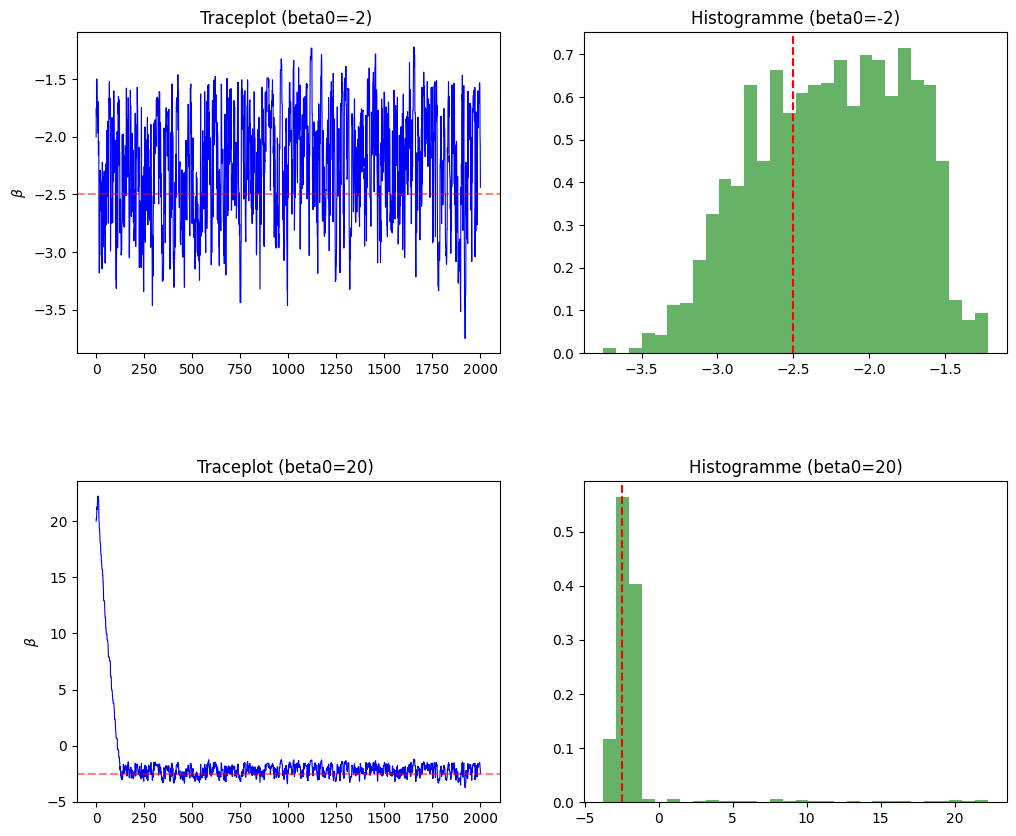

In [23]:

sigma = 0.5
Ns = 2000
beta0s = [-2, 20]
seed = 42
b_true = -2.5

# Préparation de la figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.4)

for i, beta0 in enumerate(beta0s):
    # Lancement de l'algo
    chain= mh(Ns, beta0, sigma, seed)
    
    # 1. Traceplot (Gauche)
    axes[i, 0].plot(chain, color='blue', linewidth=0.8)
    axes[i, 0].set_title(f"Traceplot (beta0={beta0}) ")
    axes[i, 0].set_ylabel(r"$\beta$")
    axes[i, 0].axhline(b_true, color='red', linestyle='--', alpha=0.5, label='Vrai beta')
    if i == 2: axes[i, 0].set_xlabel("Itérations")
    
    # 2. Histogramme (Droite)
    axes[i, 1].hist(chain, bins=30, density=True, color='green', alpha=0.6)
    axes[i, 1].set_title(f"Histogramme (beta0={beta0})")
    axes[i, 1].axvline(b_true, color='red', linestyle='--', label='Vrai beta')
    if i == 2: axes[i, 1].set_xlabel(r"$\beta$")

plt.show()

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">


### Analyse de l'influence de l'initialisation $\beta^{(0)}$

Dans cette question, nous avons fixé $\sigma = 0.5$ (la "bonne" variance trouvée précédemment) et nous observons comment le point de départ de la chaîne affecte les résultats sur 2000 itérations.

#### 1. Cas $\beta^{(0)} = -2$ (Bonne initialisation)
* **Observation :** Le point de départ ($-2$) est très proche de la vraie valeur du paramètre ($-2.5$) et du mode de la distribution *a posteriori*.
* **Traceplot :** La chaîne commence immédiatement à explorer la distribution stationnaire. On ne distingue aucune phase de transition 
* **Histogramme :** La distribution est bien centrée autour de la vraie valeur (ligne rouge).
* **Conclusion :** Quand l'initialisation est bonne, l'algorithme est efficace dès la première itération.

#### 2. Cas $\beta^{(0)} = 20$ (Mauvaise initialisation)
* **Observation :** Le point de départ ($20$) est extrêmement éloigné de la zone de haute probabilité.
* **Traceplot (La descente) :** On observe très nettement une phase transitoire au début (environ les 150-200 premières itérations). La courbe chute brutalement de 20 jusqu'à environ -2.5. 
* **Traceplot (La stationnarité) :** Une fois la zone $-2.5$ atteinte (vers l'itération 200), la chaîne se stabilise et se comporte exactement comme dans le premier cas. 
* **Histogramme :** L'histogramme est écrasé à cause de l'échelle. Bien que la majorité des points soient autour de -2.5, la présence des premières valeurs (proches de 20) étire l'axe des abscisses et biaise légèrement la moyenne si on les inclut toutes.

### Synthèse : 

Ces résultats mettent en évidence deux propriétés fondamentales des méthodes MCMC :

1.  **L'Ergodicité :** Peu importe le point de départ $\beta^{(0)}$ (même très mauvais comme 20), la chaîne finit *toujours* par converger vers la même distribution stationnaire (si on attend assez longtemps).
2.  **Le Burn-in (Période de chauffe) :** Lorsque le point de départ est mauvais, les premiers échantillons ne sont pas représentatifs de la loi cible $\pi(\beta)$. Ils correspondent au trajet de la chaîne vers la cible.

**Conclusion :**
Il est impératif de supprimer les premières itérations (par exemple les 200 ou 500 premières) avant de calculer des statistiques (moyenne, variance) ou de tracer l'histogramme, afin de ne pas biaiser l'estimation avec les valeurs de la phase transitoire.

</div>

**Q4.** À partir d'échantillons d'une chaîne avec des valeurs de $\beta^{(0)}$ et $\sigma$ bien choisies, donner le MMSE de $\beta$ ainsi que son intervalle de crédibilité à $95\%$.

In [24]:
sigma_opt = 0.5      # Celui qui donne le bon mixing
beta_init = -2.0     # Un point de départ raisonnable
N_total = 10000      # On augmente N pour avoir plus de précision statistique
burn_in = 1000

full_chain = mh(N_total, beta_init, sigma_opt, seed=42)
clean_chain = np.array(full_chain[burn_in:])
beta_mmse = np.mean(clean_chain)
cred_interval = np.percentile(clean_chain, [2.5, 97.5])

print(f"--- Résultats de l'inférence Bayésienne ---")
print(f"Vraie valeur de beta : {-2.5}")
print(f"Estimateur MMSE      : {beta_mmse:.4f}")
print(f"Intervalle à 95%     : [{cred_interval[0]:.4f}, {cred_interval[1]:.4f}]")

# Vérification si la vraie valeur est dans l'intervalle
if cred_interval[0] <= -2.5 <= cred_interval[1]:
    print("SUCCESS: La vraie valeur est bien dans l'intervalle de crédibilité.")
else:
    print("WARNING: La vraie valeur est hors de l'intervalle.")

--- Résultats de l'inférence Bayésienne ---
Vraie valeur de beta : -2.5
Estimateur MMSE      : -2.2810
Intervalle à 95%     : [-3.2126, -1.4885]
SUCCESS: La vraie valeur est bien dans l'intervalle de crédibilité.


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">


### Analyse des résultats de l'inférence 

**L'Estimateur Ponctuel (MMSE)**
* **Observation :** On obtient un $\hat{\beta}_{MMSE} \approx -2.28$ pour une vraie valeur de $-2.5$.
* **Commentaire :** L'estimation est proche de la réalité mais pas "exacte", ce qui est tout à fait normal. Cet écart s'explique par deux facteurs :
    1.  **Le bruit statistique :** Avec que $N=50$ points de données. Le jeu de données aléatoire généré contient du "bruit" qui fait que le meilleur $\beta$ pour *ces données spécifiques* n'est pas exactement le $-2.5$ théorique.
    2.  **L'influence du Prior :** Ton prior est centré en 0 ($\mathcal{N}(0,4)$). Il exerce une légère force de rappel ("shrinkage") qui tire ton estimation vers 0 (on voit que $-2.28$ est légèrement plus proche de 0 que $-2.5$). C'est un comportement attendu en régression bayésienne (régularisation).

**L'Intervalle de Crédibilité à 95% $[-3.21, -1.49]$**
* **Couverture :** La vraie valeur ($-2.5$) tombe à l'intérieur de l'intervalle. L'algorithme a donc correctement quantifié l'incertitude.
* **Significativité :** L'intervalle ne contient pas la valeur $0$ (puisque la borne supérieure est $-1.49$).
    * **Interprétation :** Cela signifie qu'il y a plus de 95% de probabilité que le coefficient $\beta$ soit strictement négatif. On peut conclure avec une forte certitude qu'il existe une relation négative significative entre la variable $x$ et la probabilité de la cible $y$.
* **Largeur de l'intervalle :** L'intervalle a une largeur d'environ $1.7$. C'est assez large, ce qui reflète le fait qu'avec seulement 50 observations binaires (0 ou 1), l'information est limitée et l'incertitude sur la valeur exacte du paramètre reste importante.

**Conclusion Générale**
L'algorithme Metropolis-Hastings a réussi à échantillonner le posterior complexe (non-gaussien à l'origine). L'estimateur MMSE fournit une bonne approximation, et l'intervalle de crédibilité offre une mesure de sécurité, rappelant que la "vraie" valeur pourrait raisonnablement se situer n'importe où entre -3.2 et -1.5.
</div>